In [0]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2019-08-17 19:02:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2019-08-17 19:02:47 (156 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [0]:
vocab_size = 1000
embedding_dim = 32
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [0]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [0]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

W0817 19:02:50.678790 139700294604672 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0817 19:02:50.684252 139700294604672 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0817 19:02:50.785155 139700294604672 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.o

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 32)            32000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                792       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 32,817
Trainable params: 32,817
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epochs = 30
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 [==============================] - 3s 168us/sample - loss: 0.5101 - acc: 0.7440 - val_loss: 0.4093 - val_acc: 0.8173
Epoch 2/30
20000/20000 [==============================] - 3s 149us/sample - loss: 0.3785 - acc: 0.8286 - val_loss: 0.3995 - val_acc: 0.8129
Epoch 3/30
20000/20000 [==============================] - 3s 150us/sample - loss: 0.3639 - acc: 0.8353 - val_loss: 0.4047 - val_acc: 0.8071
Epoch 4/30
20000/20000 [==============================] - 3s 151us/sample - loss: 0.3602 - acc: 0.8371 - val_loss: 0.4178 - val_acc: 0.8044
Epoch 5/30
20000/20000 [==============================] - 3s 151us/sample - loss: 0.3586 - acc: 0.8388 - val_loss: 0.4051 - val_acc: 0.8097
Epoch 6/30
20000/20000 [==============================] - 3s 150us/sample - loss: 0.3557 - acc: 0.8370 - val_loss: 0.4041 - val_acc: 0.8129
Epoch 7/30
20000/20000 [==============================] - 3s 147us/sample - loss: 0.3544 - acc: 0.8400 - val_lo

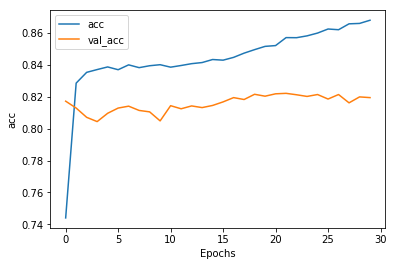

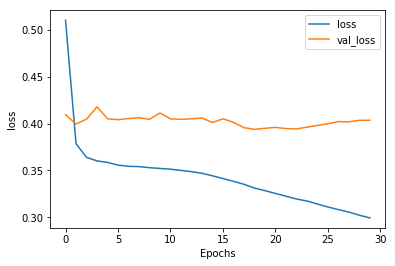

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [11]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store <OOV> <OOV> over secret <OOV> <OOV> for <OOV> <OOV> ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [12]:
e = model.layers[0]
weights = e.get_weights()[0]

print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 32)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [14]:
sentence = ["granny starting to fear spiders in the garden might be real", 
            "game of thrones season finale showing this sunday night"]

sequences = tokenizer.texts_to_sequences(sentence)

padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(model.predict(padded))

[[0.34193525]
 [0.61116207]]


In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')